In [1]:
from model_evaluate import evaluate_model

In [2]:
import sys
!{sys.executable} -m pip install xgboost



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# xg_boosting.ipynb
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


XGBOOST MODEL EVALUATION
--- XGBoost - PV Production ---
MAE: 318.148
MSE: 403243.681
RMSE: 635.015
R²: 0.971
Adjusted R²: 0.971
MAPE: 2579.93%
Explained Variance: 0.971
Sample Size: 11664
Visualization Sample: 5,000 points


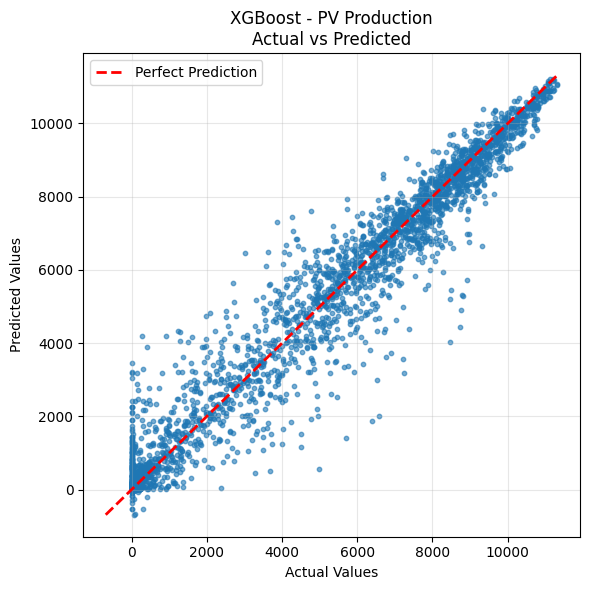

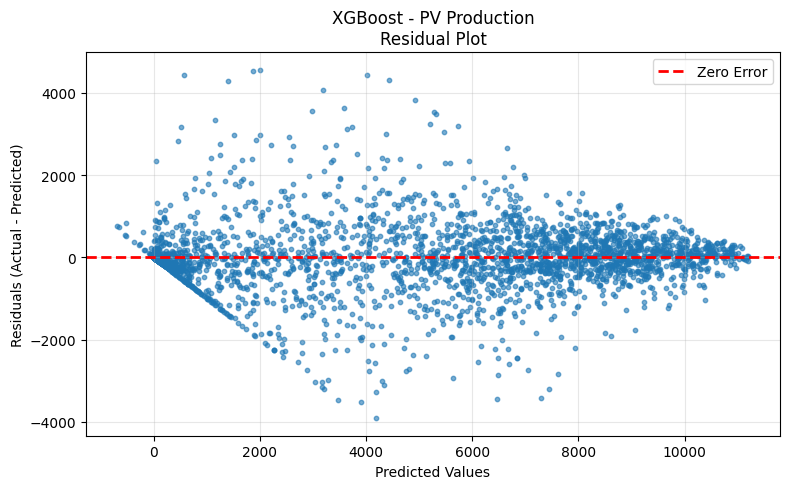

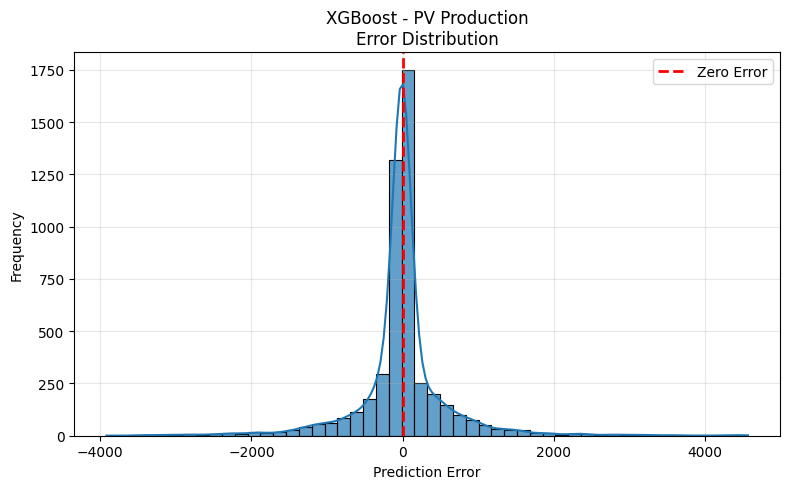

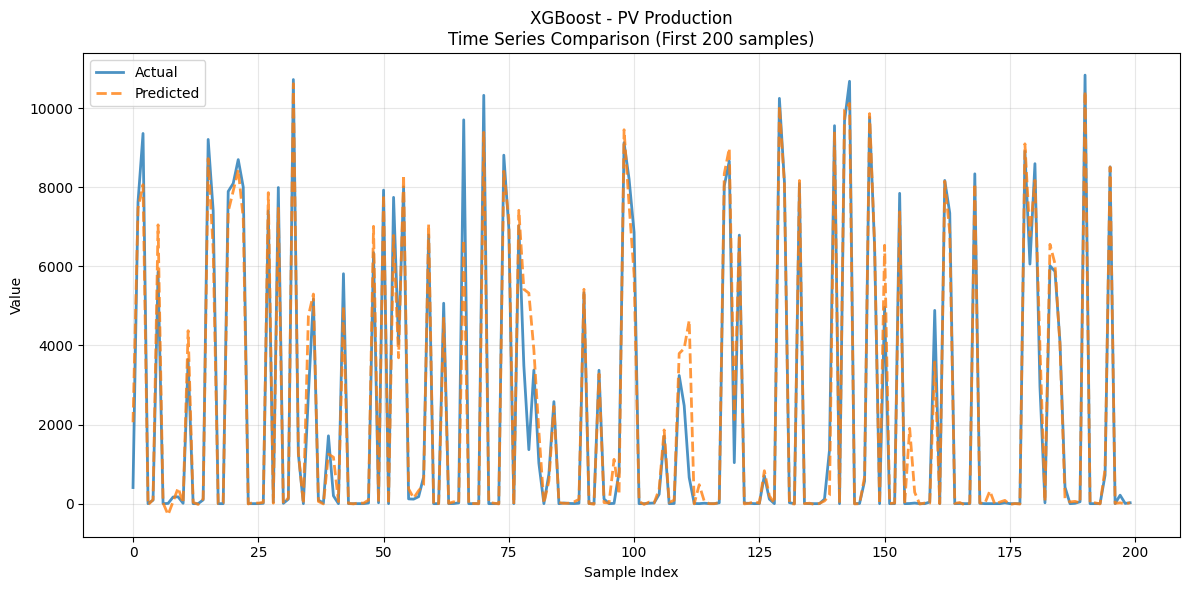

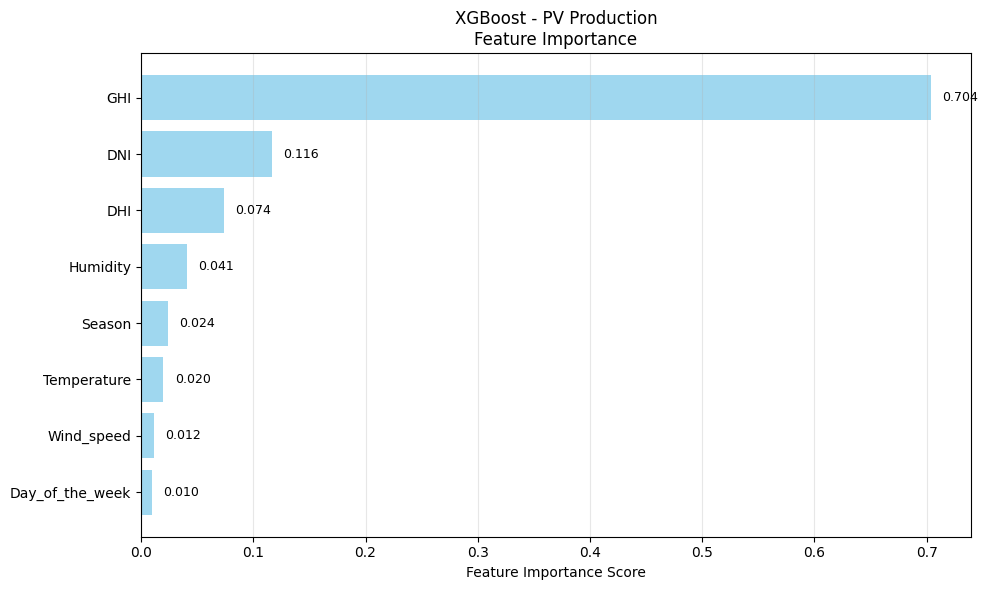


Top Features for PV Production:
           Feature  Importance
4              GHI    0.703969
3              DNI    0.116293
2              DHI    0.073680
6         Humidity    0.040743
0           Season    0.023799
7      Temperature    0.019944
5       Wind_speed    0.011727
1  Day_of_the_week    0.009845
--- XGBoost - Wind Production ---
MAE: 348.552
MSE: 230045.326
RMSE: 479.630
R²: 0.837
Adjusted R²: 0.837
MAPE: 40.69%
Explained Variance: 0.837
Sample Size: 11664
Visualization Sample: 5,000 points


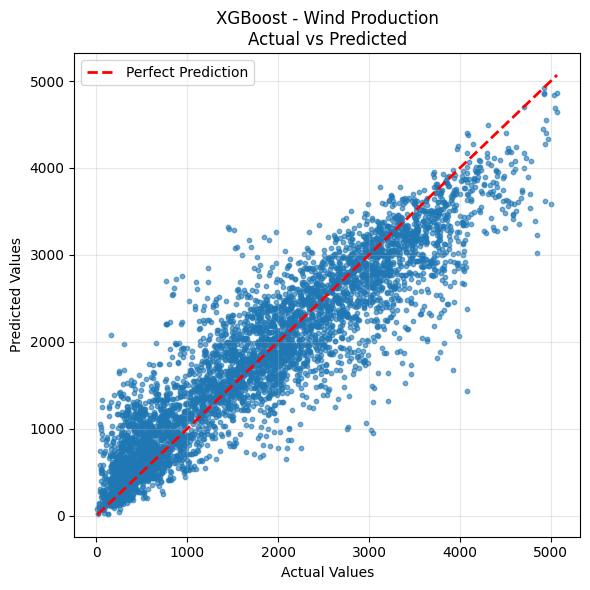

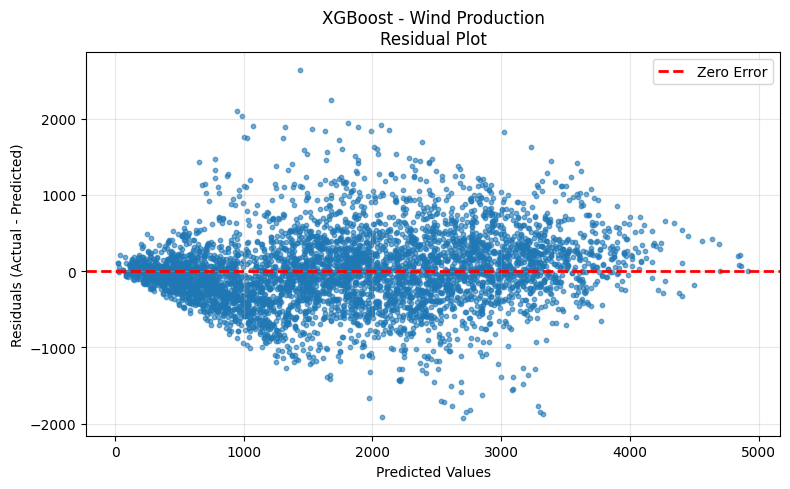

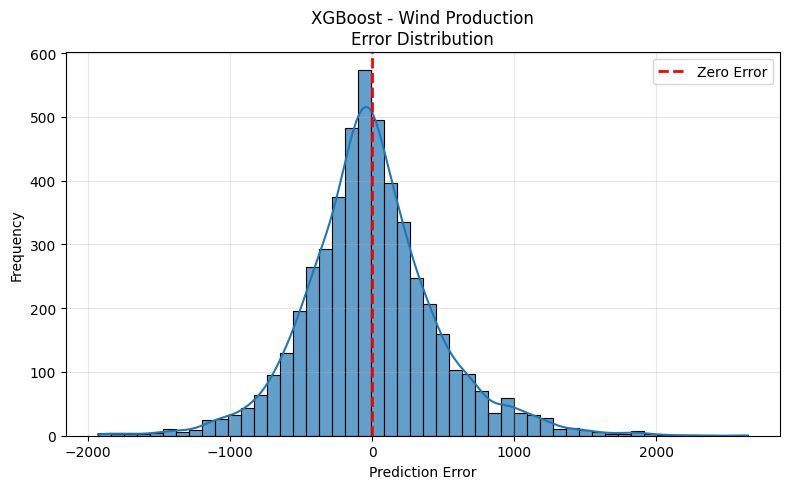

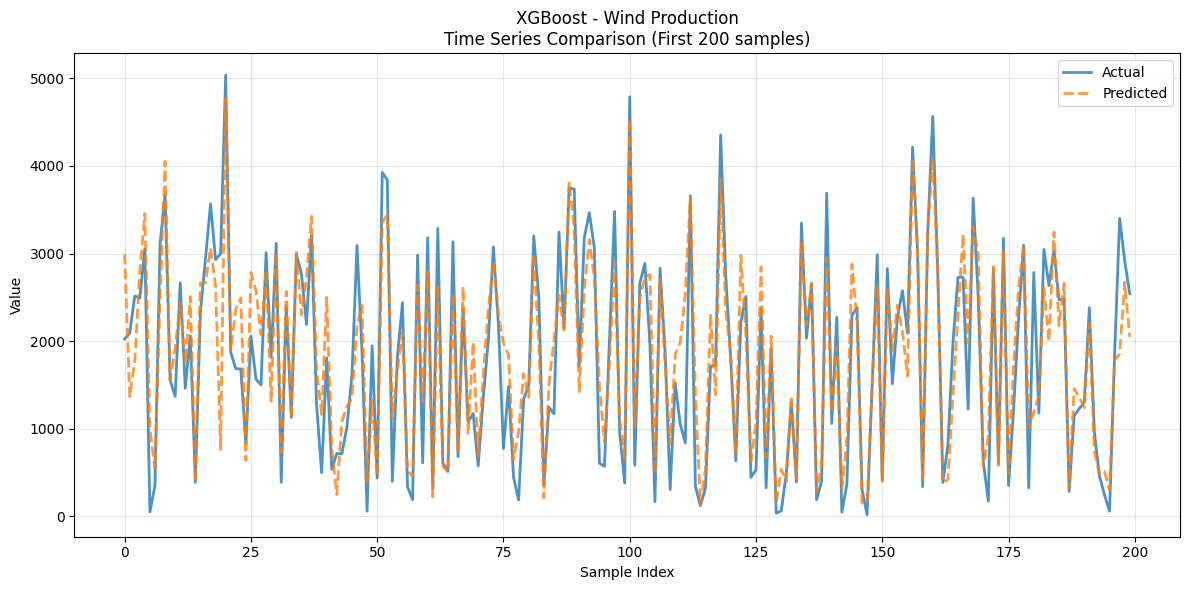

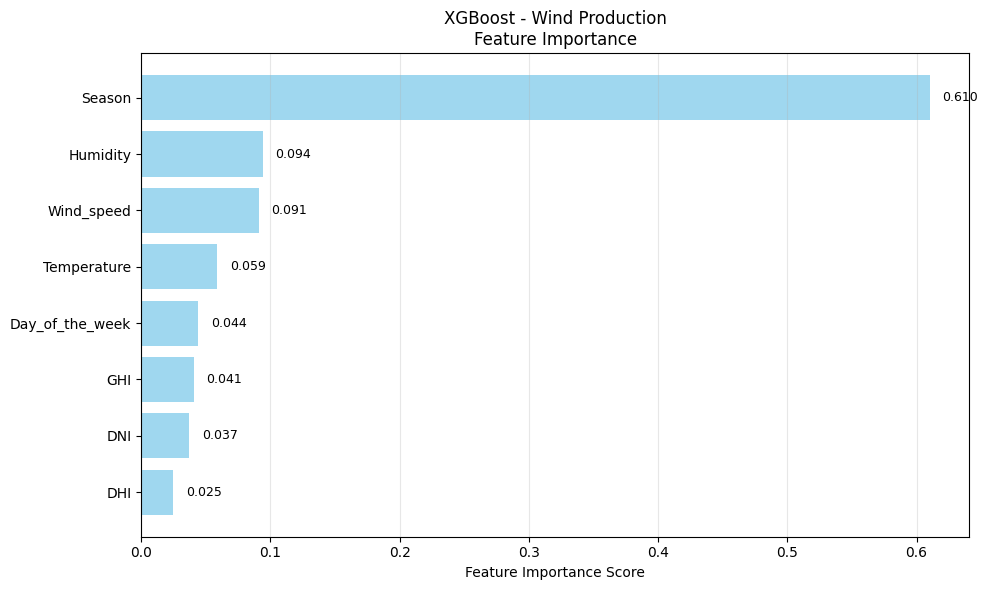


Top Features for Wind Production:
           Feature  Importance
0           Season    0.610143
6         Humidity    0.094054
5       Wind_speed    0.090894
7      Temperature    0.058578
1  Day_of_the_week    0.043833
4              GHI    0.040637
3              DNI    0.036951
2              DHI    0.024911


{'mae': np.float64(348.5524237040834),
 'mse': np.float64(230045.32598213927),
 'rmse': np.float64(479.63040560637864),
 'r2': 0.8373229503631592,
 'adj_r2': 0.8372112887246268,
 'mape': np.float64(40.69179048020942),
 'explained_variance': 0.8373232189109884}

In [4]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from model_evaluate import evaluate_model  # Consistent import

# Step 2: Load the saved training and testing data
train_data = pd.read_csv("train_multi_output.csv")
test_data = pd.read_csv("test_multi_output.csv")

# Step 3: Separate features (X) and target variables (y)
X_train = train_data[['Season', 'Day_of_the_week', 'DHI', 'DNI', 'GHI', 'Wind_speed', 'Humidity', 'Temperature']]
y_train = train_data[['PV_production', 'Wind_production']]

X_test = test_data[['Season', 'Day_of_the_week', 'DHI', 'DNI', 'GHI', 'Wind_speed', 'Humidity', 'Temperature']]
y_test = test_data[['PV_production', 'Wind_production']]

# Step 4: Initialize and train the XGBoost model
xgb_base = XGBRegressor(
    n_estimators=300,       # number of trees
    learning_rate=0.05,     # smaller = more precise
    max_depth=6,            # depth of each tree
    subsample=0.8,          # use 80% of data per tree
    colsample_bytree=0.8,   # use 80% of features per tree
    random_state=42,
    objective='reg:squarederror'
)

xgb_model = MultiOutputRegressor(xgb_base)
xgb_model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = xgb_model.predict(X_test)

# Step 6: Evaluate using consistent function - JUST THESE 2 LINES!
print("="*60)
print("XGBOOST MODEL EVALUATION")
print("="*60)

# Evaluate PV Production
evaluate_model(
    y_true=y_test['PV_production'],
    y_pred=y_pred[:, 0],  # first column corresponds to PV production
    model_name="XGBoost",
    target_name="PV Production",
    feature_names=X_train.columns,
    rf_model=xgb_model.estimators_[0]  # first estimator for PV
)


# Evaluate Wind Production  
evaluate_model(
    y_true=y_test['Wind_production'],
    y_pred=y_pred[:, 1],  # second column corresponds to Wind production
    model_name="XGBoost",
    target_name="Wind Production",
    feature_names=X_train.columns,
    rf_model=xgb_model.estimators_[1]  # second estimator for Wind
)

